In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)
from statannot import add_stat_annotation
from scipy.stats import chisquare
from scipy import stats
from scipy.stats import spearmanr

import rpy2.rinterface
#ipython extension
%load_ext rpy2.ipython
from rpy2.robjects import pandas2ri
pandas2ri.activate()


#seaborn Gr-Bk-Rd palette
pal = sns.diverging_palette(127.7, 12.2, l=53.4, n=255, center="dark")

pd.set_option('display.max_columns', 500)

%R library(GEOquery)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['GEOquery', 'Biobase', 'BiocGenerics', 'parallel', 'tools',
       'RevoUtils', 'stats', 'graphics', 'grDevices', 'utils', 'datasets',
       'RevoUtilsMath', 'methods', 'base'], dtype='<U13')

In [2]:
table = pd.read_csv("./aml_ohsu_2018/data_clinical_sample.txt", sep = '\t', comment='#')

#RNAseq_median
rna = pd.read_csv('./aml_ohsu_2018/data_RNA_Seq_expression_median.txt', sep = '\t', header=None)

rna.index = rna.iloc[:,0]
rna_t = rna.T[2:]

#merge
table = pd.merge(table, rna_t, left_on = 'SAMPLE_ID', right_on = 'Hugo_Symbol')

table.to_csv('./clinical.csv')

table = pd.read_csv('./clinical.csv', index_col=0)

# #########################################non-paired sample
# m = table['SAMPLE_TIMEPOINT'] == 'Denovo'
# m2 = table['SAMPLE_TIMEPOINT'] == 'Relapse'

# paired = pd.concat([table[m], table[m2]])
# paired = paired.sort_values(by='SAMPLE_TIMEPOINT').reset_index()

# paired['Relapse'] = paired['SAMPLE_TIMEPOINT'] == 'Relapse'

# #data output
# eset = paired.loc[:,'TSPAN6':'RP11-114I8.4']
# pset = paired.loc[:, ['SAMPLE_TIMEPOINT', 'Relapse']]

# #nomalize
# eset2 = eset.apply(pd.to_numeric, errors='coerce')
# #eset2 = eset2.apply(lambda x: np.log2(x)) 

# eset2.to_csv('./eset.csv')
# pset.to_csv('./pset.csv')

# m = pset['Relapse'] == True

# tpd52_r = eset2[m]['TPD52']
# tpd52_d = eset2[-m]['TPD52']

# dia = pd.DataFrame([tpd52_d]).T
# rel = pd.DataFrame([tpd52_r]).T

# dia.to_csv('./dia.csv', index=False)
# rel.to_csv('./rel.csv', index=False)

C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249

In [4]:
#risk == Good
g = table['KARYOTYPE'].str.contains('t\(8;21\)') == True
g2 = table['KARYOTYPE'].str.contains('t\(15;17\)') == True
g3 = table['KARYOTYPE'].str.contains('inv\(16\)') == True

#risk == poor
p = table['KARYOTYPE'].str.contains('-5') == True
p2 = table['KARYOTYPE'].str.contains('-7') == True
p3 = table['KARYOTYPE'].str.contains('del\(5q\)') == True
p4 = table['KARYOTYPE'].str.contains('COMPLEX') == True
p5 = table['KARYOTYPE'].str.contains('Abnormal\(3q\)') == True

#other == intermediate

m = g+g2+g3 #good
m3 = p+p2+p3+p4+p5 #poor
m2 = -(m+m3) #intermediate

good = table[m]
poor = table[m3]
intermediate = table[m2]

good['risk'] = 'good'
poor['risk'] = 'poor'
intermediate['risk'] = 'intermediate'

paired = pd.concat([good, intermediate, poor])
paired = paired.reset_index()

#data output
eset = paired.loc[:,'TSPAN6':'RP11-114I8.4']
pset = paired.loc[:, ['risk']]

#nomalize
eset2 = eset.apply(pd.to_numeric, errors='coerce')
#eset2 = eset2.apply(lambda x: np.log2(x)) 

eset2.to_csv('./eset.csv')
pset.to_csv('./pset.csv')

m = pset['risk'] == 'good'
m2 = pset['risk'] == 'intermediate'
m3 = pset['risk'] == 'poor'

tpd52_g = eset2[m]['TPD52']
tpd52_i = eset2[m2]['TPD52']
tpd52_p = eset2[m3]['TPD52']

good = pd.DataFrame([tpd52_g]).T
intermediate = pd.DataFrame([tpd52_i]).T
poor = pd.DataFrame([tpd52_p]).T

good.to_csv('./ohsu_g.csv', index=False)
intermediate.to_csv('./ohsu_i.csv', index=False)
poor.to_csv('./ohsu_p.csv', index=False)

In [5]:
%%R

good <- read.csv('./ohsu_g.csv')
intermediate <- read.csv('./ohsu_i.csv')
poor <- read.csv('./ohsu_p.csv')

gnum = 46
inum = 380
pnum = 26

data <- data.frame(
  name=c( rep("TPD52_good",gnum), rep("TPD52_intermediate",inum), rep("TPD52_poor",pnum)),
  
    value=c( good[1:gnum,'TPD52'], intermediate[1:inum,'TPD52'], poor[1:pnum,'TPD52'])
)

write.csv(data, './OHSU.csv', row.names=FALSE)

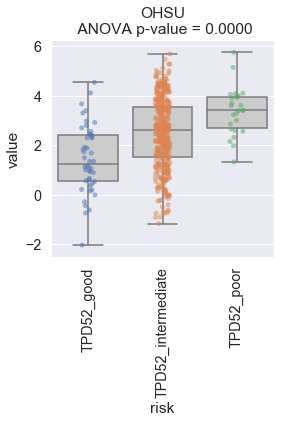

In [66]:
dfs = ['OHSU']
for k in dfs:
    table = pd.read_csv('./%s.csv' %k)
    
    g = table['name'] == 'TPD52_good'
    i = table['name'] == 'TPD52_intermediate'
    p = table['name'] == 'TPD52_poor'
    F_statistic, pVal = stats.f_oneway(table[g]['value'], table[i]['value'], table[p]['value']) 
    
    tpd52 = []
    
    gene = [tpd52]
    name = ['TPD52']

    for i in range(0, len(gene)):
        first = table['name'] == ('%s_good' %name[i].upper())
        second = table['name'] == ('%s_intermediate' %name[i].upper())
        third = table['name'] == ('%s_poor' %name[i].upper())
        gene[i] = table[first].append(table[second]).append(table[third])
        
    for i in range(0,len(gene)):
        plt.subplots(figsize = (4, 4))

        f1 = sns.boxplot(data=gene[i], x = gene[i]['name'], y = gene[i]['value'], color="0.8")
        #f1.set_ylim(0, max(max(smc2['value']),max(smc4['value']))+100)
        f1.set_title('%s\n ANOVA p-value = %.4f' %(k,pVal))
        sns.stripplot(data=gene[i], x = gene[i]['name'], y = gene[i]['value'], jitter=True, alpha=0.5)
        plt.xticks(rotation=90)
        plt.xlabel('risk')
        
#         add_stat_annotation(f1, data=gene[i], x = gene[i]['name'], y = gene[i]['value'],
#                     box_pairs=[(("%s_lowrisk" %name[i].upper()), ("%s_highrisk" %name[i].upper()))
#                                 ],
#                     test='t-test_ind', text_format='star', loc='inside', verbose=2)

        plt.savefig('./%s_%s.png' %(k, name[i]), dpi=300, bbox_inches='tight')

---
## GSE23312

In [6]:
%%R

gse <- getGEO("GSE23312",GSEMatrix=TRUE)
gse <- gse[[1]]

#exp data
eset <- exprs(gse)

#probe id to gene symbol
fset <- fData(gse)

symbols <- fset[,"CompositeSequence BioSequence Database Entry [Gene Symbol]"] #ILMN_Gene, Gene Symbol
rownames(eset) <- symbols

pset <- phenoData(gse)

#eset <- 2^(eset) #denomalizing

pset_d = pset$'overall survival status' == 'alive'
pset_r = pset$'overall survival status' == 'dead'

eset_d = eset[,pset$'overall survival status' == 'alive']
eset_r = eset[,pset$'overall survival status' == 'dead']

tpd52_d = eset_d[which(rownames(eset_d) == "TPD52")[1],]
tpd52_r = eset_r[which(rownames(eset_r) == "TPD52")[1],]

data <- data.frame(
  name=c( rep("TPD52_alive",18), rep("TPD52_dead",16)),
  value=c( tpd52_d, tpd52_r)
)

write.csv(data, './GSE23312.csv', row.names=FALSE)

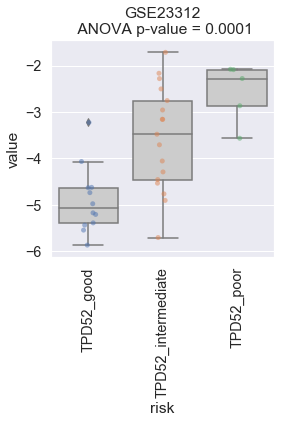

In [69]:
dfs = ['GSE23312']
for k in dfs:
    table = pd.read_csv('./%s.csv' %k)
    
    g = table['name'] == 'TPD52_good'
    i = table['name'] == 'TPD52_intermediate'
    p = table['name'] == 'TPD52_poor'
    F_statistic, pVal = stats.f_oneway(table[g]['value'], table[i]['value'], table[p]['value']) 
    
    tpd52 = []
    
    gene = [tpd52]
    name = ['TPD52']

    for i in range(0, len(gene)):
        first = table['name'] == ('%s_good' %name[i].upper())
        second = table['name'] == ('%s_intermediate' %name[i].upper())
        third = table['name'] == ('%s_poor' %name[i].upper())
        gene[i] = table[first].append(table[second]).append(table[third])
        
    for i in range(0,len(gene)):
        plt.subplots(figsize = (4, 4))

        f1 = sns.boxplot(data=gene[i], x = gene[i]['name'], y = gene[i]['value'], color="0.8")
        #f1.set_ylim(0, max(max(smc2['value']),max(smc4['value']))+100)
        f1.set_title('%s\n ANOVA p-value = %.4f' %(k,pVal))
        sns.stripplot(data=gene[i], x = gene[i]['name'], y = gene[i]['value'], jitter=True, alpha=0.5)
        plt.xticks(rotation=90)
        plt.xlabel('risk')
        
#         add_stat_annotation(f1, data=gene[i], x = gene[i]['name'], y = gene[i]['value'],
#                     box_pairs=[(("%s_lowrisk" %name[i].upper()), ("%s_highrisk" %name[i].upper()))
#                                 ],
#                     test='t-test_ind', text_format='star', loc='inside', verbose=2)

        plt.savefig('./%s_%s.png' %(k, name[i]), dpi=300, bbox_inches='tight')

---
## GSE16432

In [ ]:
%%R

gse <- getGEO("GSE16432",GSEMatrix=TRUE)
gse <- gse[[1]]

#exp data
eset <- exprs(gse)

#probe id to gene symbol
fset <- fData(gse)

symbols <- fset[,"CompositeSequence BioSequence Database Entry [Gene Symbol]"] #ILMN_Gene, Gene Symbol
rownames(eset) <- symbols

pset <- phenoData(gse)

#eset <- 2^(eset) #denomalizing

pset_d = pset$'overall survival status' == 'alive'
pset_r = pset$'overall survival status' == 'dead'

eset_d = eset[,pset$'overall survival status' == 'alive']
eset_r = eset[,pset$'overall survival status' == 'dead']

tpd52_d = eset_d[which(rownames(eset_d) == "TPD52")[1],]
tpd52_r = eset_r[which(rownames(eset_r) == "TPD52")[1],]

data <- data.frame(
  name=c( rep("TPD52_alive",20), rep("TPD52_dead",25)),
  value=c( tpd52_d, tpd52_r)
)

write.csv(data, './GSE16432.csv', row.names=FALSE)

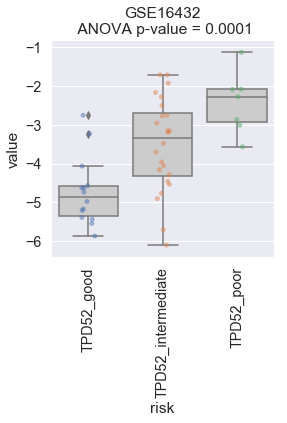

In [70]:
dfs = ['GSE16432']
for k in dfs:
    table = pd.read_csv('./%s.csv' %k)
    
    g = table['name'] == 'TPD52_good'
    i = table['name'] == 'TPD52_intermediate'
    p = table['name'] == 'TPD52_poor'
    F_statistic, pVal = stats.f_oneway(table[g]['value'], table[i]['value'], table[p]['value']) 
    
    tpd52 = []
    
    gene = [tpd52]
    name = ['TPD52']

    for i in range(0, len(gene)):
        first = table['name'] == ('%s_good' %name[i].upper())
        second = table['name'] == ('%s_intermediate' %name[i].upper())
        third = table['name'] == ('%s_poor' %name[i].upper())
        gene[i] = table[first].append(table[second]).append(table[third])
        
    for i in range(0,len(gene)):
        plt.subplots(figsize = (4, 4))

        f1 = sns.boxplot(data=gene[i], x = gene[i]['name'], y = gene[i]['value'], color="0.8")
        #f1.set_ylim(0, max(max(smc2['value']),max(smc4['value']))+100)
        f1.set_title('%s\n ANOVA p-value = %.4f' %(k,pVal))
        sns.stripplot(data=gene[i], x = gene[i]['name'], y = gene[i]['value'], jitter=True, alpha=0.5)
        plt.xticks(rotation=90)
        plt.xlabel('risk')
        
#         add_stat_annotation(f1, data=gene[i], x = gene[i]['name'], y = gene[i]['value'],
#                     box_pairs=[(("%s_lowrisk" %name[i].upper()), ("%s_highrisk" %name[i].upper()))
#                                 ],
#                     test='t-test_ind', text_format='star', loc='inside', verbose=2)

        plt.savefig('./%s_%s.png' %(k, name[i]), dpi=300, bbox_inches='tight')

---
## GSE6891

In [ ]:
%%R
gse <- getGEO("GSE6891",GSEMatrix=TRUE)
gse <- gse[[1]]

#exp data
eset <- exprs(gse)

#probe id to gene symbol
fset <- fData(gse)

symbols <- fset[,"Gene Symbol"] #ILMN_Gene, Gene Symbol
rownames(eset) <- symbols

pset <- phenoData(gse)

#eset <- 2^(eset) #denomalizing

eset_g = eset[,pset$'risk' == 'cytogenetic good']
eset_i = eset[,pset$'risk' == 'cytogenetic intermediate']
eset_p = eset[,pset$'risk' == 'cytogenetic poor']

tpd52_g = eset_g[which(rownames(eset_g) == "TPD52")[1],][1:97]
tpd52_i = eset_i[which(rownames(eset_i) == "TPD52")[1],][1:261]
tpd52_p = eset_p[which(rownames(eset_p) == "TPD52")[1],][1:93]

data <- data.frame(
  name=c( rep("TPD52_good",97), rep("TPD52_intermediate",261), rep("TPD52_poor",93)),
  value=c( tpd52_g, tpd52_i, tpd52_p)
)

write.csv(data, './GSE6891.csv', row.names=FALSE)

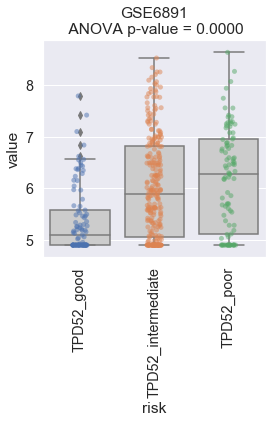

In [72]:
dfs = ['GSE6891']
for k in dfs:
    table = pd.read_csv('./%s.csv' %k)
    
    g = table['name'] == 'TPD52_good'
    i = table['name'] == 'TPD52_intermediate'
    p = table['name'] == 'TPD52_poor'
    F_statistic, pVal = stats.f_oneway(table[g]['value'], table[i]['value'], table[p]['value']) 
    
    tpd52 = []
    
    gene = [tpd52]
    name = ['TPD52']

    for i in range(0, len(gene)):
        first = table['name'] == ('%s_good' %name[i].upper())
        second = table['name'] == ('%s_intermediate' %name[i].upper())
        third = table['name'] == ('%s_poor' %name[i].upper())
        gene[i] = table[first].append(table[second]).append(table[third])
        
    for i in range(0,len(gene)):
        plt.subplots(figsize = (4, 4))

        f1 = sns.boxplot(data=gene[i], x = gene[i]['name'], y = gene[i]['value'], color="0.8")
        #f1.set_ylim(0, max(max(smc2['value']),max(smc4['value']))+100)
        f1.set_title('%s\n ANOVA p-value = %.4f' %(k,pVal))
        sns.stripplot(data=gene[i], x = gene[i]['name'], y = gene[i]['value'], jitter=True, alpha=0.5)
        plt.xticks(rotation=90)
        plt.xlabel('risk')
        
#         add_stat_annotation(f1, data=gene[i], x = gene[i]['name'], y = gene[i]['value'],
#                     box_pairs=[(("%s_lowrisk" %name[i].upper()), ("%s_highrisk" %name[i].upper()))
#                                 ],
#                     test='t-test_ind', text_format='star', loc='inside', verbose=2)

        plt.savefig('./%s_%s.png' %(k, name[i]), dpi=300, bbox_inches='tight')